# Model selection

This notebook trains multiple models, with a range of hyperparameters to assess the best fit achieved on the test set:

#### Random Forest:
    * Number of trees
    * Tree depth
    * Number of features
    * Sample size
#### SGD regression:
    * L1/ L2 regularization
#### Multi Layer Perceptron (Neural Network)
    * Network architecture
    * Activation 
    
### Main assumptions (Neeraj to review):
* feature selection through correlation (and predictions variations) (see also dri_outputs.ipynb)
* Hyperparameter selection of each model + interpretation

In [92]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import metrics
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
import json

## 1. Helper functions
* to format training data
* to train and evaluate multiple models

In [2]:
# drop prefix of each dataframe column
def drop_prefix(self, prefix):
    """ Drop prefix - method to add to pd.DataFrame S"""
    #self.columns = self.columns.str.lstrip(prefix)
    self.columns = [i[-1]for i in self.columns.str.split(prefix, 1)]

    return self
pd.core.frame.DataFrame.drop_prefix = drop_prefix

# prepare X and y split
def split_set(df, drop_cols, y_var = 'deforestation_share'):
    """
    Splits df into a target variable series (y_var), and a features
    dataframe, dropping columns in drop_cols.

    Parameters
    ----------
    df : pd.DataFrame
        dataframe containing all data.
    drop_cols : list
        list of column names to drop from df.
    y_var : int
        name of column holding the target variable.

    Returns
    -------
    X_split, y_split: features and target variable dataframes.

    """
    X_split = df.drop(columns = drop_cols)
    y_split = df[y_var].copy()
    return X_split, y_split

def drop_non_forest(df, forest_col ='closed_forest_mask_ds'):
    """returns a dataframe, subset of df, where forest_col>0, retaining only forest pixels."""
    return df[df[forest_col]>0]

def balance_classes(df, y_var = 'deforestation_share'):
    """upscales (by random concatenation of existing rows) the non 0 deforestation entries."""
    x = df[df[y_var]>0]
    y = df[df[y_var]==0].sample(n=int(len(x)/0.3), random_state=1)
    x = x.append(y)
    return x
    

In [118]:
# train models and save performance metrics
def parameters(param_set, param_names):
    """
    Returns a ddictionary with parameter names as keys.

    Parameters
    ----------
    param_set : tuple
        tuple of parameter values
    drop_cols : list
        list of parameter names in the same order as in param_set.

    Returns
    -------
    dict
    """
    params_dict = {}
    for i in range(len(param_set)):
        params_dict.update({param_names[i]: param_set[i]})
    return params_dict

def random_forest(X_train, y_train, params):
    """ Returns a trained RF model on X_train and y_train using the params parameters """
    model = RandomForestRegressor(n_estimators = params['n_estimators'],
                                  max_depth = params['max_depth'],
                                  random_state=0,
                                  max_samples = params['max_samples'],
                                  max_features = params['max_features'])
    model.fit(X_train, y_train)
    return model

def SGD_regressor(X_train, y_train, params):
    """ Returns a trained SGD regression on X_train and y_train using the params parameters. """
    model = SGDRegressor(penalty = params['penalty'],
                        max_iter = 10000,
                        random_state=0)
    model.fit(X_train, y_train)
    return model

def ml_perceptron(X_train, y_train, params):
    """ Returns a trained multilayer perceptron on X_train and y_train using the params parameters. """
    model = MLPRegressor(activation = params['activation'],
                          hidden_layer_sizes = params['hidden_layer_sizes'],
                          random_state=0)
    model.fit(X_train, y_train)
    return model

def save_data(model,
              results,
              param_dict, 
              mae,
              mse,
              r2_test,
              r2_train,
              features):
    """
    Returns the updated results dictionary with the additional entries.

    Parameters
    ----------
    model : sklearn.model
        trained model.
    results : dict
        dictionary saving the CV outcomes.
    param_dict : dict
        dictionary of parameters uswd to train model. Keys are parameter names.
    mae : numeric
        value of MAE on trained model.
    mse : numeric
        value of MSE on trained model.
    r2_test : numeric
        value of R-Squared on trained model using test set.
    r2_train : numeric
        value of R-Squared on trained model using train set.
    features : str
        name of the number of features selected for training.

    Returns
    -------
    dict compiling the results of the CV exercise so far.
    """
    for i in param_dict:
        results[i].append(param_dict[i])
    results['mae'].append(mae)
    results['mse'].append(mse)
    results['r2_test'].append(r2_test)
    results['r2_train'].append(r2_train)
    results['model'].append(model)
    results['features'].append(features)
    return results

def evaluate_model(model, X_test, y_test):
    """ Computes MAE, MSE and R2 of fitted model on test set. """
    y_hat = model.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, y_hat)
    mse = metrics.mean_squared_error(y_test, y_hat)
    r2  = metrics.r2_score(y_test, y_hat)
    return mae, mse, r2

def gen_empty_dict(params):
    """ Generate empty results dict, with the right parameter keys to save the CV exercise."""
    results = {'mae':[],
               'mse':[],
               'r2_train':[],
               'r2_test':[],
               'model':[],
               'features':[]}
    for key in params:
        results.update({key:[]})
    return results

def best_model(results, criterion):
    """ Based on criterion, identifies the best model stored in results"""
    if criterion not in ['mae', 'mse', 'r2']:
        return print('Enter valid criterion [mae, mse, r2]')
    return results[results[criterion]==min(results[criterion])]

def driver_training(X_train,
                    y_train,
                    X_test,
                    y_test,
                    params,
                    cols_dict,
                    model_def = 'RF'):
    """
    Train the model for each feature selection in cols_dict and combination of 
    hyper-parameters in params.

    Parameters
    ----------
    X_train : pd.DataFrame
        training set - features.
    y_train : pd.DataFrame
        training set - target variable.
    X_test : pd.DataFrame
        testing set - features.
    y_test : pd.DataFrame
        testing set - target variable.
    params : dict
        keys correspond to parameter names, each cointaining a list to try.
    cols_dict : dict
        keys correspond to name of feature selection, values a list of column names to keep from X_set.
    model_def : str
        RF, SGD or MLP, defines model to be trained.

    Returns
    -------
    pd.DataFrame compiling the results of the CV exercise.
    """
    
    # results dict
    results = gen_empty_dict(params)
    # unpack parameters
    prod = list(product(*params.values()))
    param_names = list(params.keys())
    n = len(prod*len(cols_dict))
    i =0 
    for features, cols in cols_dict.items():
        X_train_sub = X_train[cols]
        X_test_sub = X_test[cols]
        
        for param_set in prod:

            param_dict = parameters(param_set, param_names)

            if model_def == 'RF':
                model = random_forest(X_train_sub, y_train, param_dict)
            elif model_def == 'SGD':
                model = SGD_regressor(X_train_sub, y_train, param_dict)
            elif model_def == 'MLP':
                model = ml_perceptron(X_train_sub, y_train, param_dict)
            else:
                print('Invalid model requested - must be in ["RF", "SGD", "MLP"]')
                return

            mae, mse, r2_test = evaluate_model(model, X_test_sub, y_test)
            r2_train = model.score(X_train_sub, y_train)
            results = save_data(model,
                                results,
                                param_dict, 
                                mae,
                                mse,
                                r2_test,
                                r2_train,
                                features)
            i+=1
            print(f'training.... {"{:.2%}".format(i/n)}')
    return  pd.DataFrame(results)
                
    


## 2. Load and format data
* include all features
* restrict to subset of features with highest correlation 
### 2.1. All features

In [4]:
# load training set
train = pd.read_csv('output/pilot_training_2019.csv')

# load test set
test = pd.read_csv('output/national_training_2020.csv')



In [5]:
# remove column prefixes
train.drop_prefix('pilot_');
test.drop_prefix('national_');


In [6]:
# drop non forest points
train = drop_non_forest(train, forest_col ='closed_forest_mask_ds')
test = drop_non_forest(test, forest_col ='closed_forest_mask_ds')

In [131]:
# split features and target variable
drop_cols =['aoi_ds',
            'year',
            'deforestation_share',
            'distance_to_deforestation',
            'closed_forest_mask_ds',
            'x',
            'y']

deforestation_vars = ['deforestation_share_1_lag',
                      'distance_to_deforestation_1_lag']
y_var = 'deforestation_share'

X_train, y_train = split_set(train, drop_cols, y_var)
X_test, y_test = split_set(test, drop_cols, y_var)


In [137]:
X_test=X_test[X_train.columns]
sum(X_test.columns != X_train.columns) # must be zero!

0

### 2.2. Features with highest correlation to deforestation

In [9]:
# get correlation matrix
all_df = X_train.join(y_train)
cor = all_df.corr()

<AxesSubplot:>

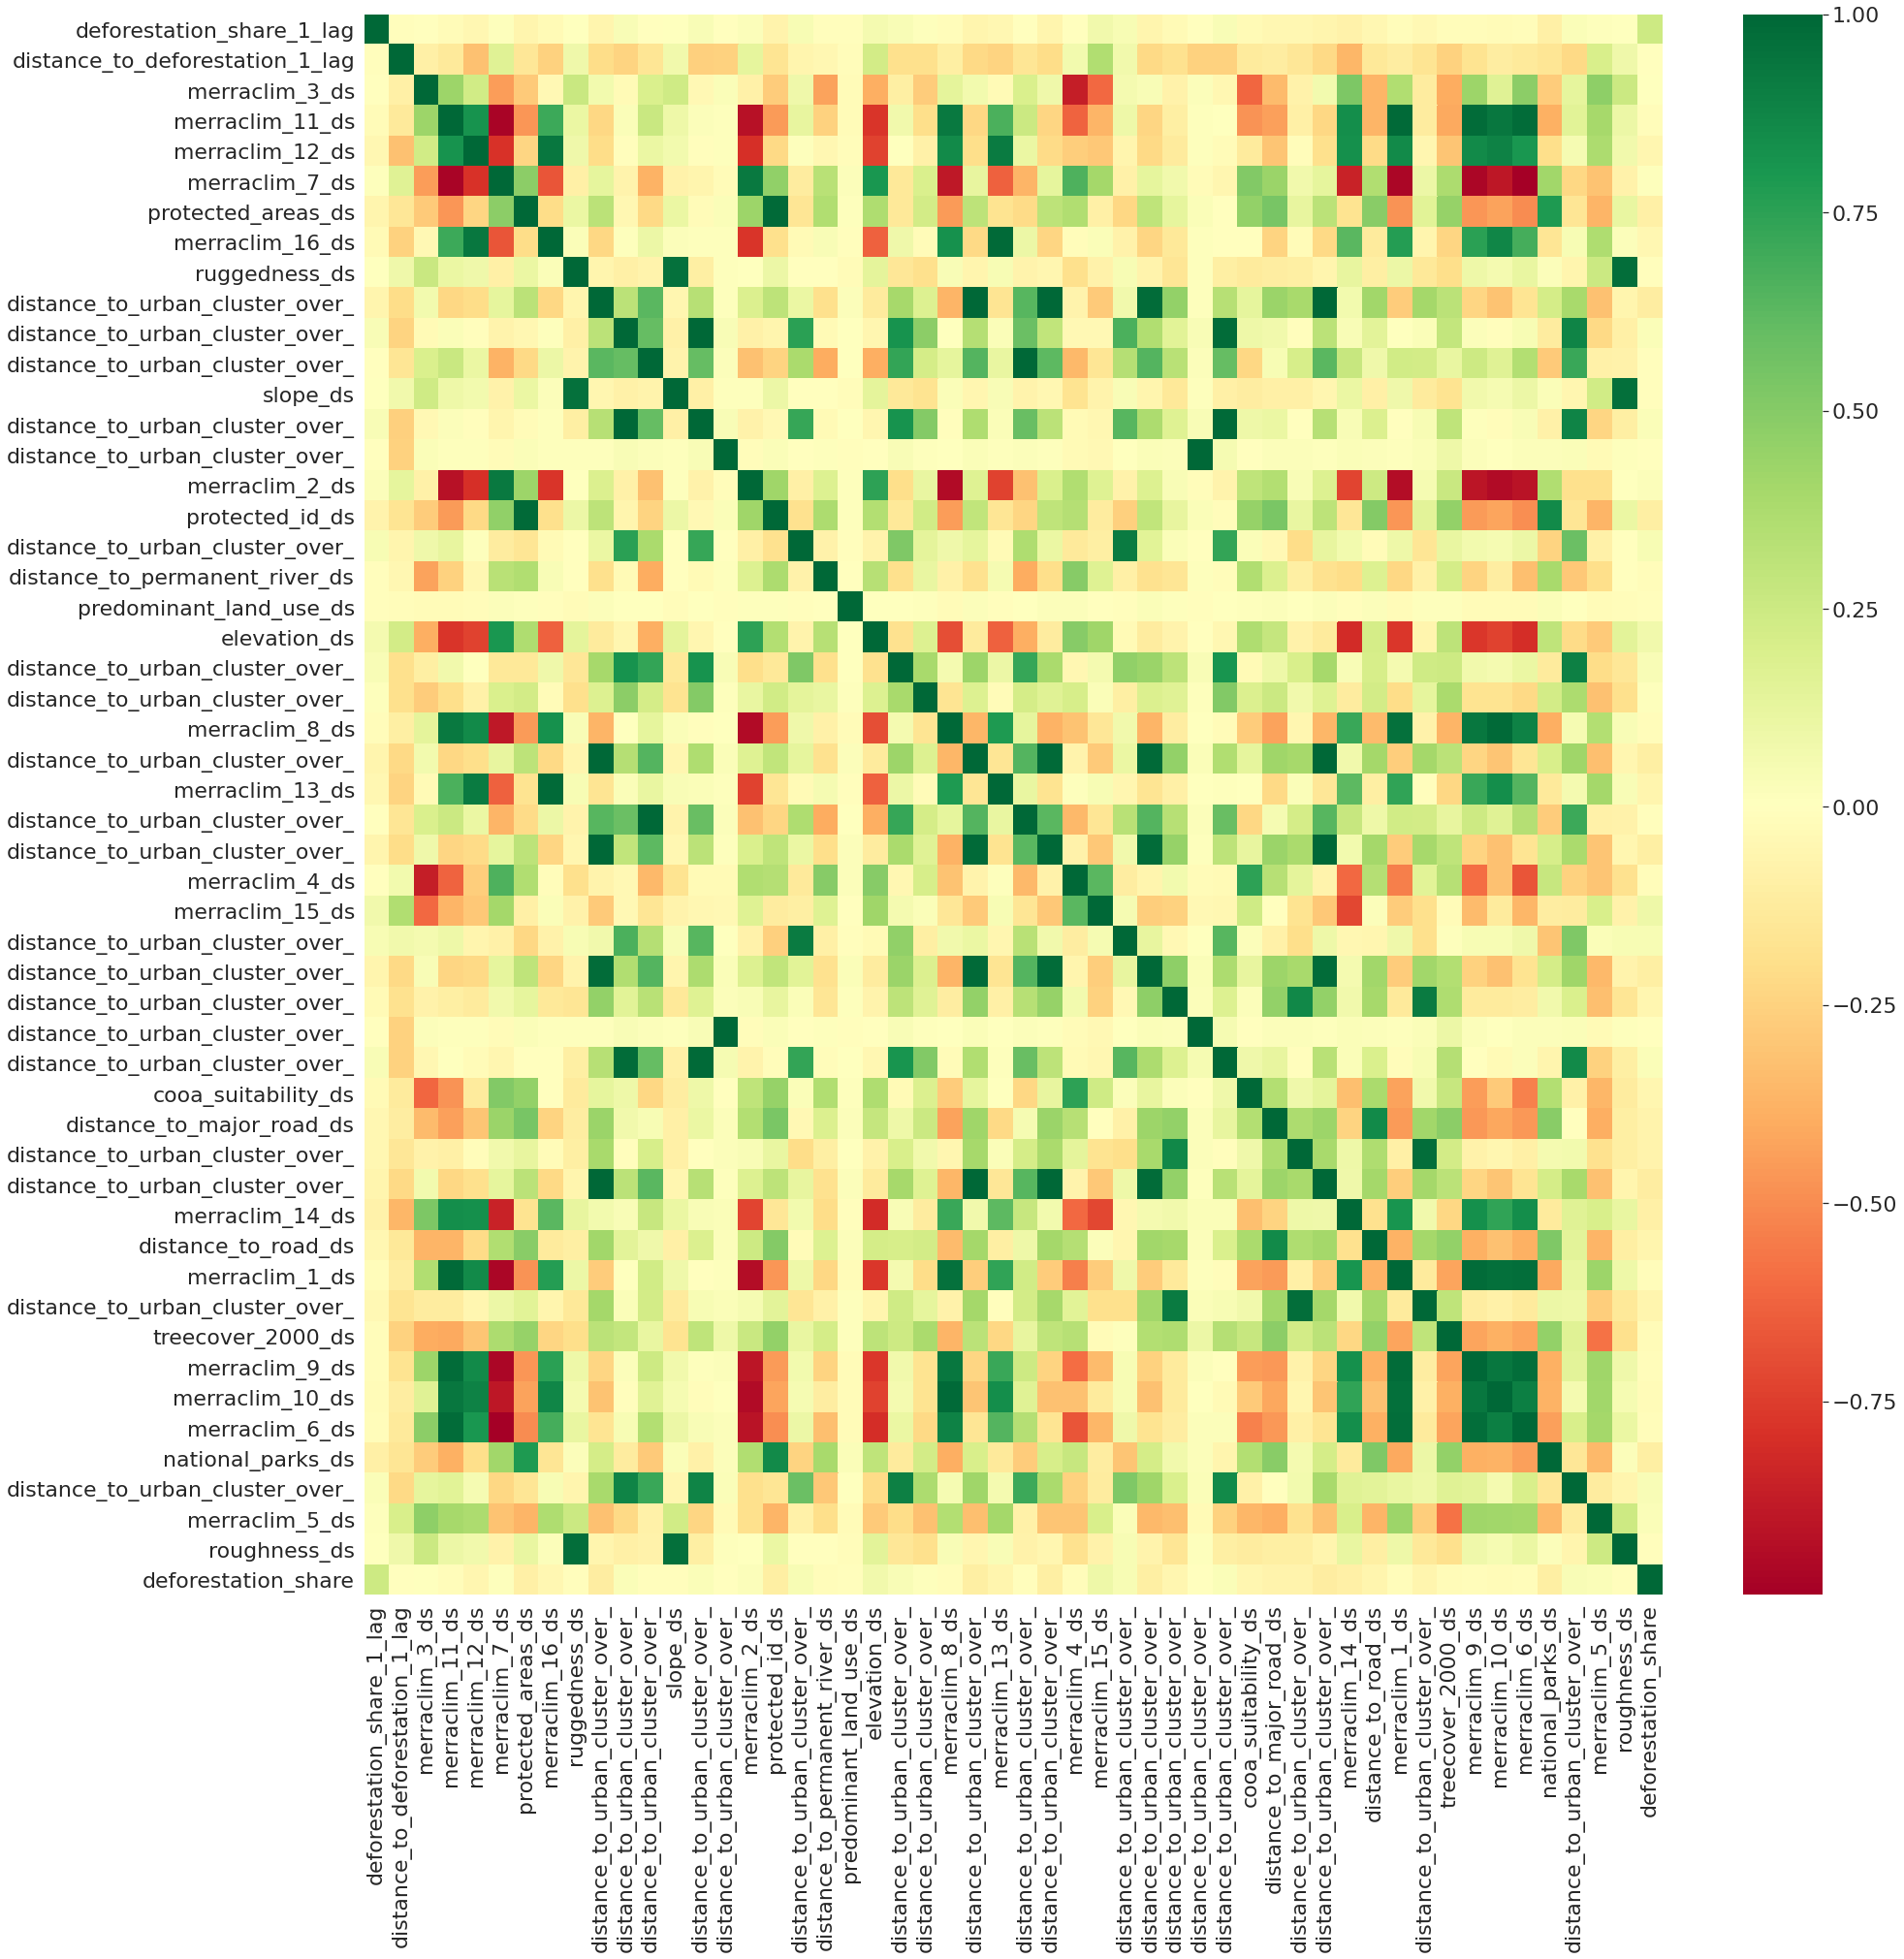

In [10]:
# visualise correlation
plt.figure(figsize=(30,30))
sns.set(font_scale=2)
col_disp = [i[:31] for i in all_df.columns] # names too long otherwise
sns.heatmap(cor, cmap="RdYlGn",xticklabels=col_disp,yticklabels=col_disp)

Note that most of the variables have very low level of correlation with the depvar, the highest one being around 0.25 for lagged deforestation share. Let's draw a list of the features with a correlation larger than 0.025, 0.05 and 0.1

In [11]:
keep_0025 = cor['deforestation_share'][abs(cor['deforestation_share'])>0.025][:-1]
keep_0050 = cor['deforestation_share'][abs(cor['deforestation_share'])>0.05][:-1]
keep_0100 = cor['deforestation_share'][abs(cor['deforestation_share'])>0.1][:-1]

In [12]:
print(f'Of the total {X_train.shape[1]} raw features:')
print(f'Cor of 0.025 keeps {len(keep_0025)} features')
print(f'Cor of 0.05 keeps {len(keep_0050)} features')
print(f'Cor of 0.1 keeps {len(keep_0100)} features')


Of the total 51 raw features:
Cor of 0.025 keeps 31 features
Cor of 0.05 keeps 20 features
Cor of 0.1 keeps 8 features


## 3. Model selection and hyper-parameter tuning


In [13]:
# set of column subset to test (all features, features with correlation higher than 0.025, 0.05 and 0.1)
cols_dict = {'all': list(X_train.columns),
             'corr_0.025': list(keep_0025.index),
             'corr_0.05': list(keep_0050.index),
             'corr_0.1': list(keep_0100.index)
    
}
# evaluation criterion
criterion = 'mae'

### 3.1. Random Forest

In [15]:
# hyperparameters to test
params = {'n_estimators' : [50, 75, 100],
          'max_depth' : [20, 50],
          'max_features' : [0.5, 'sqrt'],
          'max_samples' : [0.2, 0.5, 0.7]
}




In [16]:
# train all models
res_RF = driver_training(X_train,
                         y_train,
                         X_test,
                         y_test,
                         params,
                         cols_dict,
                         model_def = 'RF')

training.... 1.04%
training.... 2.08%
training.... 3.12%
training.... 4.17%
training.... 5.21%
training.... 6.25%
training.... 7.29%
training.... 8.33%
training.... 9.38%
training.... 10.42%
training.... 11.46%
training.... 12.50%
training.... 13.54%
training.... 14.58%
training.... 15.62%
training.... 16.67%
training.... 17.71%
training.... 18.75%
training.... 19.79%
training.... 20.83%
training.... 21.88%
training.... 22.92%
training.... 23.96%
training.... 25.00%
training.... 26.04%
training.... 27.08%
training.... 28.12%
training.... 29.17%
training.... 30.21%
training.... 31.25%
training.... 32.29%
training.... 33.33%
training.... 34.38%
training.... 35.42%
training.... 36.46%
training.... 37.50%
training.... 38.54%
training.... 39.58%
training.... 40.62%
training.... 41.67%
training.... 42.71%
training.... 43.75%
training.... 44.79%
training.... 45.83%
training.... 46.88%
training.... 47.92%
training.... 48.96%
training.... 50.00%
training.... 51.04%
training.... 52.08%
training.

In [89]:
# Inspect the results
res_RF.describe()

,mae,mse,r2_train,r2_test,n_estimators,max_depth,max_samples
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.039997,0.009666,0.617756,-0.069355,62.500000,35.000000,0.466667
std,0.009825,0.000749,0.134449,0.082836,12.565617,15.078741,0.206559
min,0.025947,0.009066,0.362883,-0.406600,50.000000,20.000000,0.200000
25%,0.033029,0.009282,0.498544,-0.061695,50.000000,20.000000,0.200000
50%,0.040853,0.009427,0.637264,-0.042845,62.500000,35.000000,0.500000
75%,0.046117,0.009597,0.731469,-0.026776,75.000000,50.000000,0.700000
max,0.063972,0.012715,0.829273,-0.002923,75.000000,50.000000,0.700000


In [100]:
# identify set of hyperparameters with best fit
best_model(res_RF, criterion)

,mae,mse,r2_train,r2_test,model,features,n_estimators,max_depth,max_features,max_samples
83,0.025947,0.009299,0.686946,-0.02874,"(DecisionTreeRegressor(max_depth=50, max_featu...",corr_0.1,50,50,sqrt,0.7


### 3.2. SDG regression

In [116]:
# parameters
params = {'penalty' : ['l1', 'l2']}

In [119]:
# train all models
res_SGD = driver_training(X_train,
                         y_train,
                         X_test,
                         y_test,
                         params,
                         cols_dict,
                         model_def = 'SGD')

training.... 12.50%
training.... 25.00%
training.... 37.50%
training.... 50.00%
training.... 62.50%
training.... 75.00%
training.... 87.50%
training.... 100.00%


In [120]:
# Inspect the results
res_SGD.describe()

,mae,mse,r2_train,r2_test
count,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00
mean,7.984019e+17,9.028501e+35,-1.343152e+39,-9.987815e+37
std,4.495385e+17,8.901006e+35,1.252312e+39,9.846774e+37
min,2.338333e+17,8.313608e+34,-3.916878e+39,-3.030745e+38
25%,5.419555e+17,3.807445e+35,-1.677128e+39,-1.276294e+38
50%,6.823660e+17,5.555206e+35,-8.961198e+38,-6.145469e+37
75%,1.027251e+18,1.153708e+36,-6.409325e+38,-4.212001e+37
max,1.610192e+18,2.739647e+36,-1.155935e+38,-9.196962e+36


In [121]:
# identify set of hyperparameters with best fit
best_model(res_SGD, criterion)

,mae,mse,r2_train,r2_test,model,features,penalty
4,2.338333e+17,8.313608e+34,-1.155935e+38,-9.196962e+36,"SGDRegressor(max_iter=10000, penalty='l1', ran...",corr_0.05,l1


### 3.3. Neural Network (MLP)

In [122]:
# parameters
params = {'activation':['relu', 'identity'],
          'hidden_layer_sizes':[(10, 2),
                                (10, 10, 2),
                                (10, 20, 8, 2),
                                (20, 10, 5, 2)]}
                                                             


In [123]:
# train all models
res_MLP = driver_training(X_train,
                         y_train,
                         X_test,
                         y_test,
                         params,
                         cols_dict,
                         model_def = 'MLP')

training.... 3.12%
training.... 6.25%
training.... 9.38%
training.... 12.50%
training.... 15.62%
training.... 18.75%
training.... 21.88%
training.... 25.00%
training.... 28.12%
training.... 31.25%
training.... 34.38%
training.... 37.50%
training.... 40.62%
training.... 43.75%
training.... 46.88%
training.... 50.00%
training.... 53.12%
training.... 56.25%
training.... 59.38%
training.... 62.50%
training.... 65.62%
training.... 68.75%
training.... 71.88%
training.... 75.00%
training.... 78.12%
training.... 81.25%
training.... 84.38%
training.... 87.50%
training.... 90.62%
training.... 93.75%
training.... 96.88%
training.... 100.00%


In [124]:
# Inspect the results
res_MLP.describe()

,mae,mse,r2_train,r2_test
count,32.000000,32.000000,32.000000,32.000000
mean,0.041158,0.049030,-0.489831,-4.423947
std,0.043446,0.182345,1.573636,20.172041
min,0.019604,0.009056,-8.307713,-114.057853
25%,0.020373,0.009251,-0.034183,-0.063994
50%,0.021888,0.009291,-0.001603,-0.027855
75%,0.030782,0.009618,-0.000024,-0.023403
max,0.188711,1.040067,0.010498,-0.001818


In [125]:
# identify set of hyperparameters with best fit
best_model(res_MLP, criterion)

,mae,mse,r2_train,r2_test,model,features,activation,hidden_layer_sizes
0,0.019604,0.009352,-0.001338,-0.034564,"MLPRegressor(hidden_layer_sizes=(10, 2), rando...",all,relu,"(10, 2)"


## 4. Save model and selected features
The features subset yielding the best results is now identified. Let's save them so that the dataset we'll use to build predictions can be retrieved. We need to replace in the test set X_test the variable deforestation_lag with the y_test values. The current deforetation is what will make the lag deforestation in the next period.

Let's also save the best model to be able to make projections without the need to re-train

In [138]:
# Prediction set
test.to_csv('output/prediction_set_2021.csv', index = False)

In [97]:
# save features subsets
file = open('output/features_subsets.json', 'w')
json.dump(cols_dict, file)
file.close()

In [111]:
# save best model for each subset of explanatory features
models = {}
for subset in cols_dict:
    reg = best_model(res_RF[res_RF['features'] == subset], criterion)['model'].values[0]
    models.update({subset: reg})
dump(models, 'output/dri_model.joblib')

['output/dri_model.joblib']

## 5. Conclusion
The linear model and the Neural Network both perform very poorly, and are unable to catpure the complex correlations within the dataset.

The preferred model is the Random Forest, achieveing the lowest MAE on the test set. Interestingly the lowes MAE is achieved when including ony the features with a correlation higher (in absolute terms) than 0.1 with the dependent variable, whith the following hyperparameters:

* number of trees: 50
* tree depth: 50
* max features: sqrt
* sample 70%

It seems that the most important features (those with a correlation of 0.1 or higher) drive the results in all models, so we can restrict the feature space to these ones.